# Train and Tune Linear Regression Model with MultioutputRegressor

In [1]:
from pathlib import Path

import numpy as np
import optuna
import optuna.visualization as vis
import pandas as pd

from src.config import Config
from src.data import time_series_split
from src.models.factory import build_model
from src.plots import plot_forecast_diagnostics, plot_price_overlay, plot_price_overlay_next_30
from src.preprocessing import get_preprocessor
from src.train import ModelTrainer
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
rng = set_seed(cfg.runtime.seed)
horizon = 30

2025-08-23 21:29:44,783 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / cfg.data.name_features_full)
df_full

,date,open,high,low,close,volume,adj_close,pos,neu,neg,...,target_30,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,quarter,dow
0,2008-08-19,11478.089844,11478.169922,11318.500000,11348.549805,171580000,11348.549805,0.042369,0.942838,0.014793,...,-0.001807,-0.015602,0.003778,0.007168,-0.009451,-0.011943,0.004085,NaN,3,1
1,2008-08-20,11345.940430,11454.150391,11290.580078,11417.429688,144880000,11417.429688,0.043197,0.772239,0.184564,...,-0.032678,-0.011463,-0.015602,0.003778,0.007168,-0.009451,-0.011943,0.004085,3,2
2,2008-08-21,11415.230469,11476.209961,11315.570312,11430.209961,130020000,11430.209961,0.001049,0.777835,0.221116,...,-0.015136,0.006051,-0.011463,-0.015602,0.003778,0.007168,-0.009451,-0.011943,3,3
3,2008-08-22,11426.790039,11632.129883,11426.790039,11628.059570,138790000,11628.059570,0.100609,0.738009,0.161382,...,-0.036480,0.001119,0.006051,-0.011463,-0.015602,0.003778,0.007168,-0.009451,3,4
4,2008-08-25,11626.190430,11626.269531,11362.629883,11386.250000,148610000,11386.250000,0.003025,0.902580,0.094395,...,-0.052416,0.017161,0.001119,0.006051,-0.011463,-0.015602,0.003778,0.007168,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,0.065429,0.684537,0.250034,...,NaN,-0.034473,0.012866,-0.002746,0.001395,0.007312,-0.003273,0.005254,2,0
1978,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,0.086932,0.714076,0.198991,...,NaN,-0.015084,-0.034473,0.012866,-0.002746,0.001395,0.007312,-0.003273,2,1
1979,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0.114712,0.673349,0.211939,...,NaN,0.015600,-0.015084,-0.034473,0.012866,-0.002746,0.001395,0.007312,2,2
1980,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,0.040575,0.727080,0.232345,...,NaN,0.016235,0.015600,-0.015084,-0.034473,0.012866,-0.002746,0.001395,2,3


In [4]:
train, val, test, forecast = time_series_split(df_full, train_ratio=0.8, val_ratio=0.1, horizon=horizon)

In [5]:
drop_cols = ["open", "high", "low", "close", "volume", "adj_close"]
target_cols = [c for c in df_full.columns if c == "target" or c.startswith("target_")]
feature_cols = [c for c in df_full.columns if c not in target_cols + ["date"] + drop_cols]

X_train, y_train = train[feature_cols], train[target_cols]
X_val, y_val = val[feature_cols], val[target_cols]
X_test, y_test = test[feature_cols], test[target_cols]
X_forecast = forecast[feature_cols]

In [6]:
X_test.to_parquet(Path(cfg.data.processed_dir) / "X_test_30.parquet", index=False)

In [7]:
preprocessor, _ = get_preprocessor(X_train)

In [8]:
model = build_model(
    kind="linreg",
    horizon=horizon,
    random_state=cfg.runtime.seed,
    multioutput=True,
    tree_method=None,
    n_jobs=None,
)

trainer = ModelTrainer(
    model=model,
    name=f"linreg_h{horizon}",
    config={
        "optimization_metric": "rmse",
        "gap": 0,
        "seed": cfg.runtime.seed
    },
    preprocessor=preprocessor,
    y_scale=True
)

2025-08-23 21:29:45,122 - INFO - ModelTrainer - Initialized ModelTrainer for model: linreg_h30


In [9]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=cfg.runtime.seed),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)
)

study.optimize(lambda trial: trainer.objective(trial, X_train, y_train), n_trials=30)

best_params = study.best_trial.user_attrs["best_params"]

pd.Series(best_params).to_csv(Path(cfg.data.processed_dir) / cfg.model.best_params_enet_mo_best_30)
print("Best params:", best_params)

[I 2025-08-23 21:29:45,181] A new study created in memory with name: no-name-e7ff359b-cca4-4773-8c0b-d2ad65850961
2025-08-23 21:29:45,182 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+00, tolerance: 3.910e-02
  model = cd_fast.enet_coordinate_descent(
[I 2025-08-23 21:29:45,500] Trial 0 finished with value: 0.010132885964950848 and parameters: {'alpha': 0.0001329291894316216, 'l1_ratio': 0.9507143064099162, 'max_iter': 3500, 'selection': 'cyclic'}. Best is trial 0 with value: 0.010132885964950848.
2025-08-23 21:29:45,500 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective d

Best params: {'alpha': 0.009311403260660715, 'l1_ratio': 0.8397646127079323, 'max_iter': 2000, 'selection': 'random', 'random_state': 42}


In [10]:
best_model = build_model("linreg", horizon=horizon, **best_params)

trainer = ModelTrainer(
    model=best_model,
    name=f"linreg_h{horizon}",
    config={
        "optimization_metric": "rmse",
        "gap": 0,
        "seed": cfg.runtime.seed
    },
    preprocessor=preprocessor,
    y_scale=True
)
trainer.fit(X_train, y_train, X_val, y_val)

2025-08-23 21:29:51,818 - INFO - ModelTrainer - Initialized ModelTrainer for model: linreg_h30
2025-08-23 21:29:51,818 - INFO - ModelTrainer - Starting model training...


In [11]:
results = {
    "train": trainer.evaluate(X_train, y_train),
    "val": trainer.evaluate(X_val, y_val),
    "test": trainer.evaluate(X_test, y_test)
}

meta = {
    "model": "enet_mo_30",
    "with_sentiment": True,
    "horizon": horizon
}

flat_rows = []
for split, metrics in results.items():
    row = {"split": split, **meta, **metrics}
    flat_rows.append(row)

results_df = pd.DataFrame(flat_rows)

results_df.to_csv(Path(cfg.data.processed_dir) / cfg.data.results_direct_multi_step, index=False)
results_df

2025-08-23 21:29:51,860 - INFO - ModelTrainer - Evaluating model...
2025-08-23 21:29:51,866 - INFO - ModelTrainer - Evaluating model...
2025-08-23 21:29:51,871 - INFO - ModelTrainer - Evaluating model...


,split,model,with_sentiment,horizon,mae,mse,rmse,smape,r2
0,train,enet_mo_30,True,30,0.008275,0.000171,0.013069,1.613774,0.026789
1,val,enet_mo_30,True,30,0.006734,0.000086,0.009247,1.629838,-0.043735
2,test,enet_mo_30,True,30,0.007701,0.000102,0.010108,1.621985,-0.028545


In [12]:
model_path = trainer.save()

In [13]:
vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_contour(study).show()
vis.plot_edf(study).show()

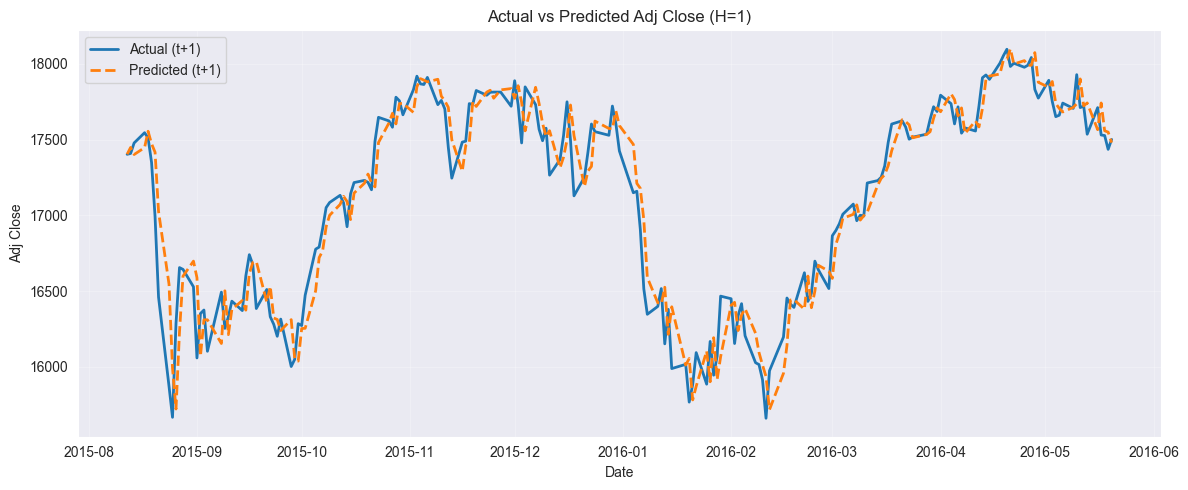

In [14]:
y_pred = trainer.predict(X_test)
plot_price_overlay(df_full, X_test, y_pred, Path(cfg.data.fig_dir) / "pred_vs_actual_adj_close_price_plus_1.png")

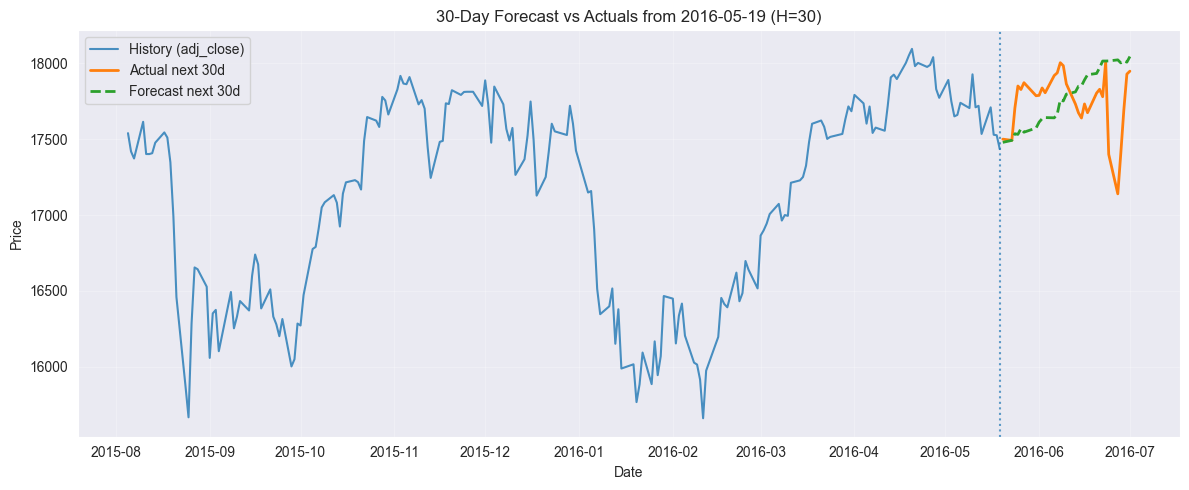

In [15]:
plot_price_overlay_next_30(df_full, test, y_pred, horizon=horizon, hist_window=200, path=Path(cfg.data.fig_dir) / "pred_vs_actual_adj_close_price_plus_30.png")

In [16]:
y_true = np.asarray(y_test)

anchor_idx = int(X_test.index[-1])
last_price = df_full.loc[anchor_idx, "adj_close"]

future_rows = df_full.iloc[anchor_idx + 1: anchor_idx + 1 + horizon]
future_dates = pd.to_datetime(future_rows["date"].to_numpy())

actual_price_path = last_price * np.exp(np.cumsum(y_true[-1]))
pred_price_path = last_price * np.exp(np.cumsum(y_pred[-1]))

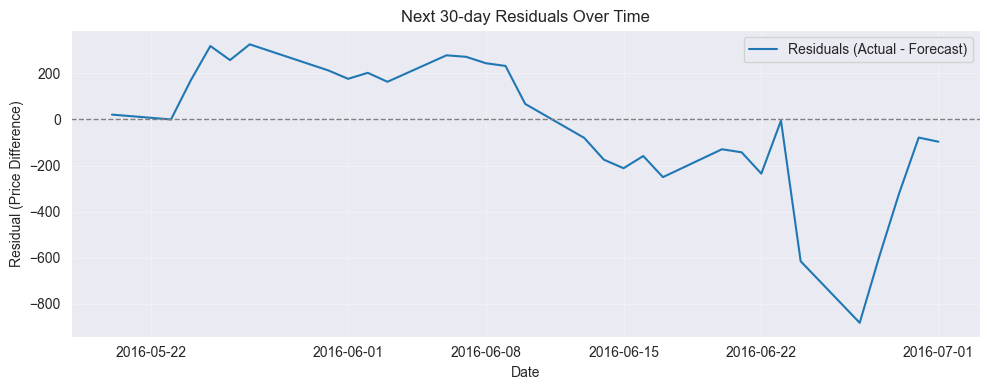

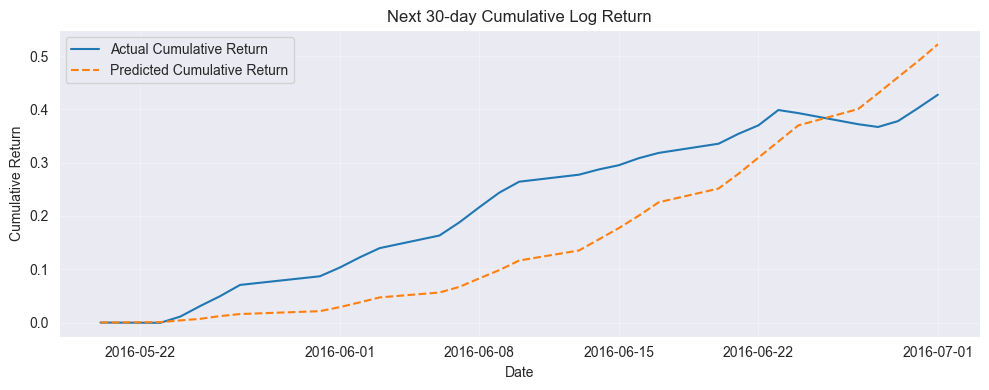

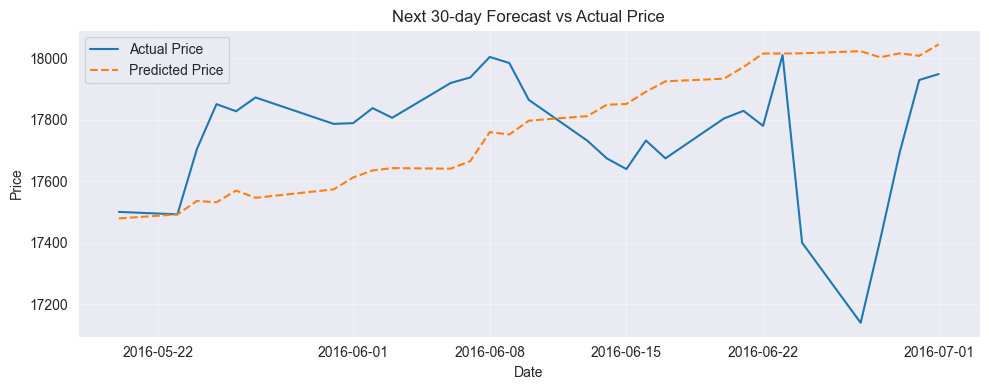

In [17]:
plot_forecast_diagnostics(
    future_dates=future_dates,
    actual_price_path=actual_price_path,
    pred_price_path=pred_price_path,
    path=Path(cfg.data.fig_dir) / "forecast_eval_plus_30.png"
)